In [ ]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import shutil

In [ ]:
transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder("/content/drive/MyDrive/plant/Plant_leave_diseases_dataset_with_augmentation", transform=transform)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: /content/drive/MyDrive/plant/Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [ ]:
indices = list(range(len(dataset)))

In [ ]:
split = int(np.floor(0.85 * len(dataset)))

In [ ]:
validation = int(np.floor(0.70 * split))

In [ ]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [ ]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [ ]:
np.random.shuffle(indices)

In [ ]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
targets_size = len(dataset.class_to_idx)

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
device = "cuda"
model = CNN(targets_size)

In [ ]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
import numpy as np
from datetime import datetime  # Import datetime module for time tracking

def batch_gd(model, criterion, train_loader, validation_loader, epochs, optimizer, device):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)  # Corrected variable name to match usage

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss  # Corrected variable name to match usage

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses  # Corrected variable name to match usage


In [ ]:
device = "cuda"

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5, optimizer, device
)


Epoch : 1/5 Train_loss:1.570 Validation_loss:1.543 Duration:0:05:05.075720
Epoch : 2/5 Train_loss:1.321 Validation_loss:1.238 Duration:0:05:05.512447
Epoch : 3/5 Train_loss:1.103 Validation_loss:1.048 Duration:0:05:05.808788
Epoch : 4/5 Train_loss:0.921 Validation_loss:0.870 Duration:0:05:04.819274
Epoch : 5/5 Train_loss:0.731 Validation_loss:0.794 Duration:0:05:04.904237


In [ ]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

In [ ]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

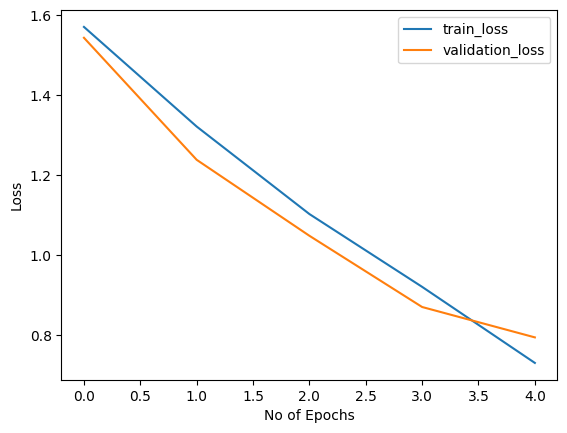

In [ ]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Move the model to the GPU (if not already on the GPU)
model.to(device)

def accuracy(loader):
    n_correct = 0
    n_total = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            _, predictions = torch.max(outputs, 1)

            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]

    model.train()  # Set the model back to training mode

    acc = n_correct / n_total
    return acc

# Now calculate accuracies for train, test, and validation loaders
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)


In [ ]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9075278810408922
Test Accuracy : 0.881491922367993
Validation Accuracy : 0.8718030486638179


In [ ]:
transform_index_to_disease = dataset.class_to_idx

In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)

In [ ]:
transform_index_to_disease

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Background_without_leaves',
 5: 'Blueberry___healthy',
 6: 'Cherry___Powdery_mildew',
 7: 'Cherry___healthy',
 8: 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 9: 'Corn___Common_rust',
 10: 'Corn___Northern_Leaf_Blight',
 11: 'Corn___healthy',
 12: 'Grape___Black_rot',
 13: 'Grape___Esca_(Black_Measles)',
 14: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 15: 'Grape___healthy',
 16: 'Orange___Haunglongbing_(Citrus_greening)',
 17: 'Peach___Bacterial_spot',
 18: 'Peach___healthy',
 19: 'Pepper,_bell___Bacterial_spot',
 20: 'Pepper,_bell___healthy',
 21: 'Potato___Early_blight',
 22: 'Potato___Late_blight',
 23: 'Potato___healthy',
 24: 'Raspberry___healthy',
 25: 'Soybean___healthy',
 26: 'Squash___Powdery_mildew',
 27: 'Strawberry___Leaf_scorch',
 28: 'Strawberry___healthy',
 29: 'Tomato___Bacterial_spot',
 30: 'Tomato___Early_blight',
 31: 'Tomato___Late_blight',
 32: 'Toma

Original :  ve/MyDrive/Plant_leave_diseases_dataset_with_augmentation/Apple___healthy/image (1004)


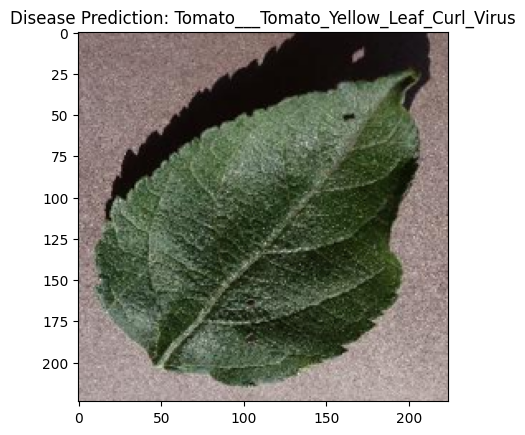

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def single_prediction(image_path, model, transform_index_to_disease, device):
    image = Image.open(image_path)
    image = image.resize((224, 224))

    # Use torchvision.transforms.ToTensor() to convert the image to a tensor
    transform = transforms.Compose([transforms.ToTensor()])
    input_data = transform(image)
    input_data = input_data.view((-1, 3, 224, 224))

    # Move the input data to the same device as the model
    input_data = input_data.to(device)

    output = model(input_data)
    output = output.detach().cpu().numpy()  # Move output to CPU for further processing
    index = np.argmax(output)

    print("Original : ", image_path[12:-4])
    pred = transform_index_to_disease[index]

    plt.imshow(image)
    plt.title("Disease Prediction: " + pred)
    plt.show()

# Example usage:
single_prediction("/content/drive/MyDrive/Plant_leave_diseases_dataset_with_augmentation/Apple___healthy/image (1004).JPG", model, transform_index_to_disease, device)
